# Example for using threshold choice mehods

In this example, we use the credit-a dataset. We split the data 50% train and 50% test. With Train data we learn a model (J48 Unpruned) and show the cors curves of that model in the test data with four different threshold choice methods:
* Train Optimal
* Test Optimal
* Score Driven
* Rate Driven

Load requiered libraries

In [1]:
library("RWeka")
library(caret)
source("options.R")
source("Threshold_methods.R")
source("cost_functions.R")

source("plots.R")

Loading required package: lattice
Loading required package: ggplot2


Constants

In [2]:
##resolution
km<-RESOLUTION_EMPIRICAL_CURVES 
##proportion of data for training
prop<-0.5
dataset<-"credit-a.arff"
bfactor<-2 # bfactor

Read and prepare Data

In [3]:
#Read 
data <- read.arff(paste("data/",dataset,sep=""))

# Class is the last feature
posParamEstudio<-length(data[1,])
nomParamEstudio<-names(data)[posParamEstudio]
#sort
w<-data[sample(nrow(data)),]

tam<-length(data[,1])

## nomcl is the minority class
nomcl<-unique(data[nomParamEstudio])
if(sum(data[,nomParamEstudio]==nomcl[[1]][1])>(tam/2)){
     mnom=nomcl[[1]][1]
} else mnom=nomcl[[1]][2]

indiceStrat<-createDataPartition(w[,posParamEstudio], p = prop,list=FALSE)
train<-w[indiceStrat,]
test<-w[-indiceStrat,]


Learn the Model and compute train and test probabilities and classes

In [4]:
#learn the model 
ob<-paste(nomParamEstudio,"~.",sep="")
#model <- Logistic(ob, data = train)
model<- J48(ob, data = train, control = Weka_control(U = TRUE,A=TRUE))
#compute train  probabilities and classes
allprobstrain<-predict(model, newdata = train,type=c("probability"))
probstrain<-allprobstrain[,mnom]
    
     
cltrain<-c()
for (i in 1:length(train[,1]))
      {
        if(train[i,nomParamEstudio]==mnom)  {cltrain[i]<-1 }
        else cltrain[i]<-0
      }
      
     
inptrain<-cbind(cltrain,probstrain)
# rank according probs     
x <- t(inptrain)
zord <- order(x[2,])
zordrev <- rev(zord)
screv <- x[,zordrev]
inptrain <- t(screv) #Decreasing order
          
#compute test  probabilities and classes
allprobs<-predict(model, newdata = test,type=c("probability"))
probs<-allprobs[,mnom]    
    
cl<-c()
for (i in 1:length(test[,1]))
   {
     if(test[i,posParamEstudio]==mnom)
      {cl[i]<-1 }
      else cl[i]<-0 
        # if (probs[i,1]==0)probs[i,1]<-0.0000001
    }
      
      #
inp<-cbind(cl,probs)
#sort test probs
x <- t(inp)
zord <- order(x[2,])
zordrev <- rev(zord)
screv <- x[,zordrev]
inp <- t(screv) #Decreasing order
      
   

Show Train Cost Lines

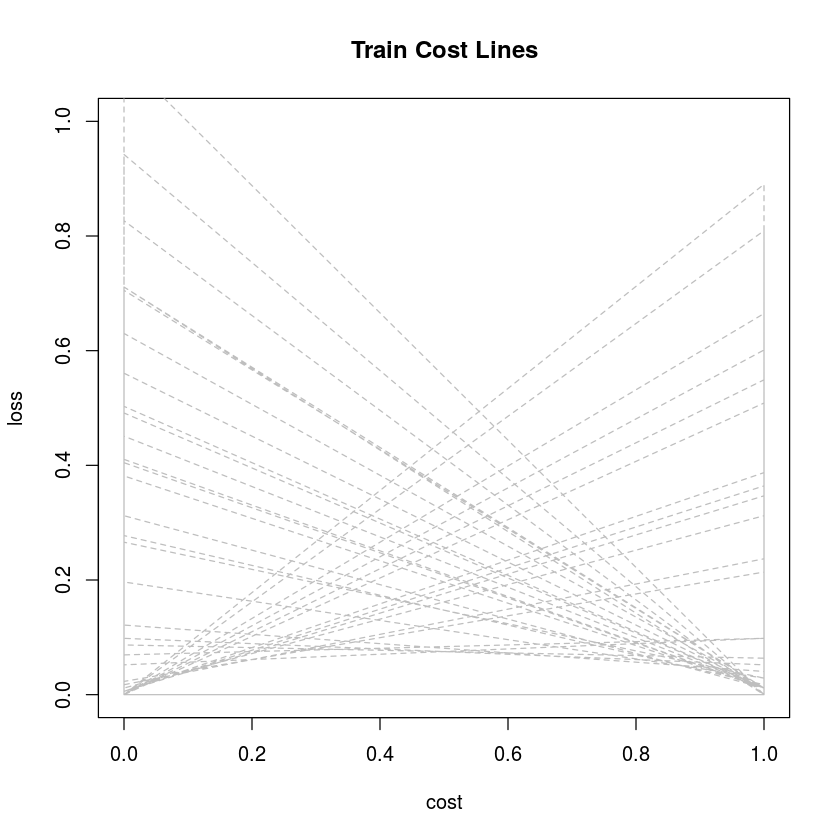

In [5]:


xrtrain<-MinCost(inptrain,title="Train Cost Lines")

Show Test Cost Lines

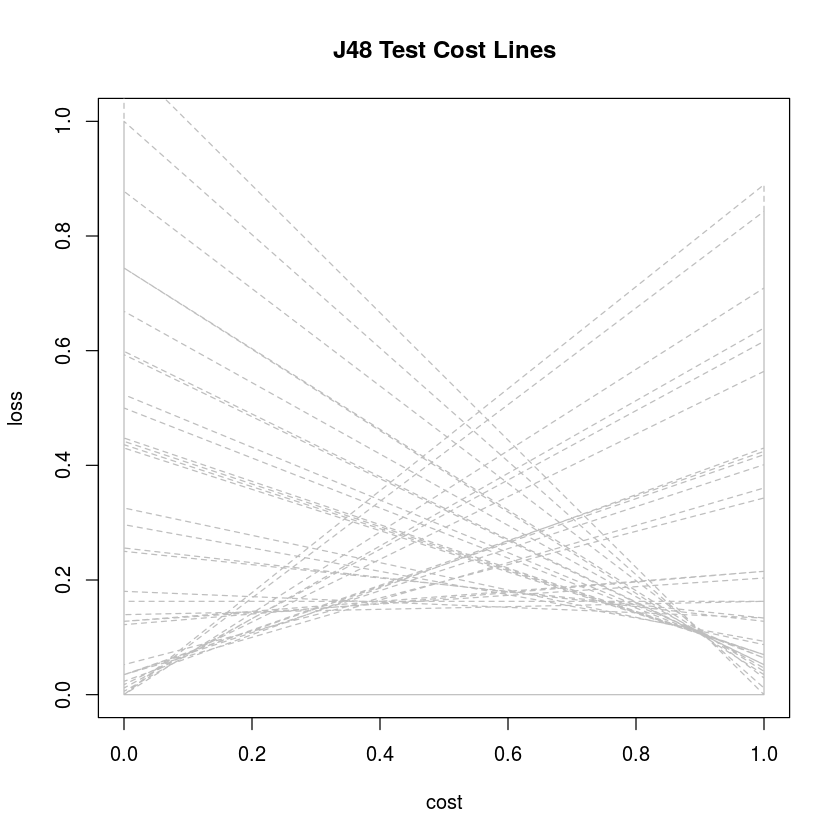

In [6]:
xr<-MinCost(inp,title="J48 Test Cost Lines")

Show ROC  Test curve

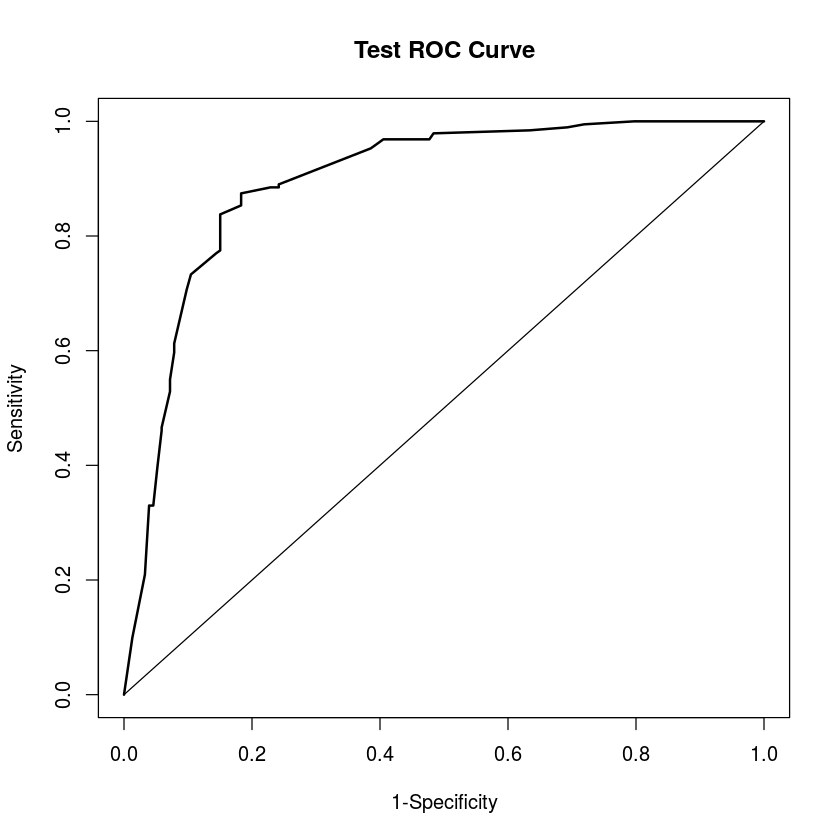

In [7]:
ROC(inp,title="Test ROC Curve")

Show cost curves for four different threshold choice methods
* Train Optimal
* Test Optimal
* Score Driven
* Rate Driven

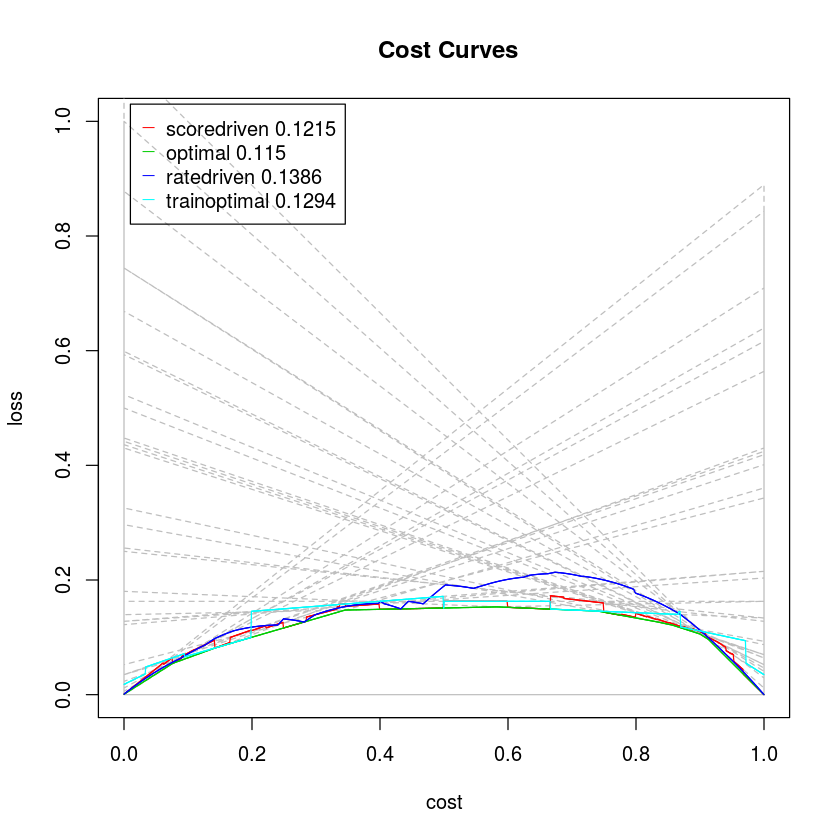

In [8]:
     
      vcreal<-c()
      vchat<-c()
      curvoptimal<-list()
      curvoptimal$points<-c()
      curvoptimal$selth<-c()
      curvtrainoptimal<-list()
      curvtrainoptimal$points<-c()        
      curvscored<-list()
      curvscored$points<-c()    
      curvrated<-list()
      curvrated$points<-c()
      opta<-0
      trainopt<-0
      scoa<-0
      scda<-0
     ## We compute the cost of each of the curves by traverse from 0 to 1 all the possibles C
  ### we use km as resolution
      for (it in 1:km) 
      {
        creal<-it/km          
        chat<-creal
        
        vcreal[it]<-creal
        vchat[it]<-chat
        
        
        ####test_optimal_test 
        thredsh<-ThresMin(inp,chat,xr$yf)    
        coptimal<-comp_cost_single(inp[,1],inp[,2],thredsh,creal)
        opta<-opta+coptimal
        curvoptimal$title<-"optimal"
        curvoptimal$points[it]<-coptimal
        curvoptimal$selth[it]<-whichLC(xr$yf,coptimal,creal)
        
        
        ####train_optimal_test 
        thredsh<-ThresMin(inptrain,chat,xrtrain$yf)
        ctrainoptimal<-comp_cost_single(inp[,1],inp[,2],thredsh,creal)
        trainopt<-trainopt+ctrainoptimal        
        curvtrainoptimal$title<-"trainoptimal"
        curvtrainoptimal$points[it]<-ctrainoptimal
        curvtrainoptimal$selth[it]<-whichLC(xr$yf,ctrainoptimal,creal)
        
        
        
        ####Rate_driven 
        allt<-RateDrivenThresFunCdisROCCOST_empat(inp,chat)
        thredsh1<-allt[1]
        thredsh2<-allt[2]
        pesos<-allt[3]
        cratedrive<-pesos*comp_cost_single(inp[,1],inp[,2],thredsh1,creal)+(1-pesos)*comp_cost_single(inp[,1],inp[,2],thredsh2,creal)
        scda<-scda+cratedrive
        curvrated$title<-"ratedriven"
        curvrated$points[it]<-cratedrive
                      
        
        ####score_driven_test
        thredsh<-ScoreDrivenThres(inp,chat)
        cscoredriven<-comp_cost_single(inp[,1],inp[,2],thredsh,creal)        
        scoa<-scoa+  cscoredriven
        curvscored$title<-"scoredriven"
        curvscored$points[it]<-cscoredriven
        
      }
      
      #curves and areas
      curvoptimal$area<-opta/km
      curvtrainoptimal$area<-trainopt/km
      curvscored$area<-scoa/km
      curvrated$area<-scda/km
      
      xr<-MinCost(inp,title=" Cost Curves") 
      plot_curves_testl(list(curvscored,curvoptimal,curvrated,curvtrainoptimal),title="",newplot=FALSE)
      
       